# Short Time Fourier Transfer

* [Exploring the Short-Time Fourier Transform: Analyzing Time-Varying Audio Signals](https://medium.com/@ongzhixuan/exploring-the-short-time-fourier-transform-analyzing-time-varying-audio-signals-98157d1b9a12)

> ### Wideband Analysis (Short Window)
> With a short window, the STFT offers **higher time resolution**, allowing you to capture rapid changes in the audio signal. This is particularly useful for analyzing transient or rapidly evolving sounds, such as speech or percussive instruments. However, a short window results in **lower frequency resolution** (as number of dimensions (= samples in window) is small), which can make it difficult to distinguish between closely spaced frequency components.
>
> ### Narrowband Analysis (Long Window)
> A long window provides **higher frequency resolution**, enabling you to **identify small frequency differences** in the audio signal. This can be beneficial when analyzing steady-state sounds, like sustained musical notes or constant background noise. However, a long window reduces time resolution, making it less suitable for capturing rapidly changing events in the audio signal.
>
> ### Position of the Windows (Overlap)
> The amount of overlap between consecutive windows can impact the quality of the STFT analysis. **Overlapping windows can help reduce the loss of information at the edges of the windows**, providing a smoother and more continuous representation of the time-frequency characteristics of the audio signal. The degree of overlap depends on the specific application, but **typical values range from 50% to 75%**. However, increased overlap may also result in **higher computational complexity**, as more windows need to be processed.

In [1]:
from IPython.display import (
    Audio, 
    display
)
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def display_stft_as_spectrogram(
    stft: np.ndarray,
    sampling_rate: int, 
    slide_size: int
):
    """
    Args:
        stft: normalized stft data of shape (num_windows, num_frequencies).T = (num_frequencie, num_windows).
              Let idx as the index into num_windows. Then, idx * window_size * sampling_rate gives the time.
              
              Note:
              Each row is a frequency, not a window data. 
                 This is to have the same structure (y-axis is frequency) as in spectrogram.
                 See https://librosa.org/doc/main/glossary.html#term-spectrogram.
        sampling_rate: rate by which the audio is recorded.
        slide_size: window slide size
    """
    magnitude = np.abs(stft)
    # TODO: Normalize STFT before converting dB.
    
    dB = librosa.amplitude_to_db(magnitude)
    
    plt.figure(figsize=(12,5))
    librosa.display.specshow(
        # log_spectrogram, 
        dB,
        sr=sampling_rate, 
        hop_length=slide_size, 
        x_axis="time", 
        y_axis="linear"
    )
    # plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    plt.colorbar()
    plt.show()

# Sound Data

In [3]:
data, sampling_rate = librosa.load("./data/jfk.flac")
N = num_total_samples = data.shape[0]

print(f"sampling_rate:[{sampling_rate}], duration:[{data.shape[0] / 22500}] seconds") 
display(Audio(data=data, rate=sampling_rate))

sampling_rate:[22050], duration:[10.78] seconds


# Sound Wave


# Audio Wave (Time Series)

Amplitude of the signal on the y-axis and time along the x-axis

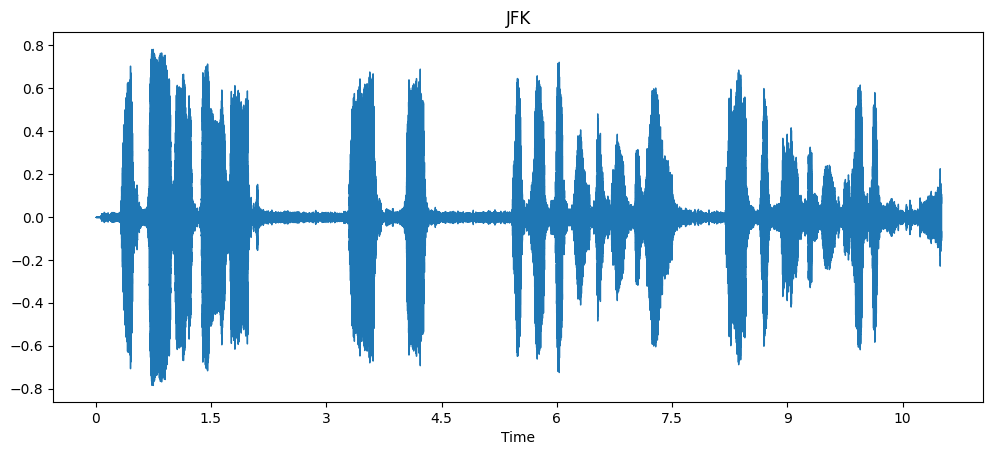

In [4]:
plt.figure().set_figwidth(12)
plt.title("JFK")
librosa.display.waveshow(y=data, sr=sampling_rate)

# Frequency Spectrum

The frequency values are on the x-axis, usually plotted on a logarithmic scale, while their amplitudes are on the y-axis.

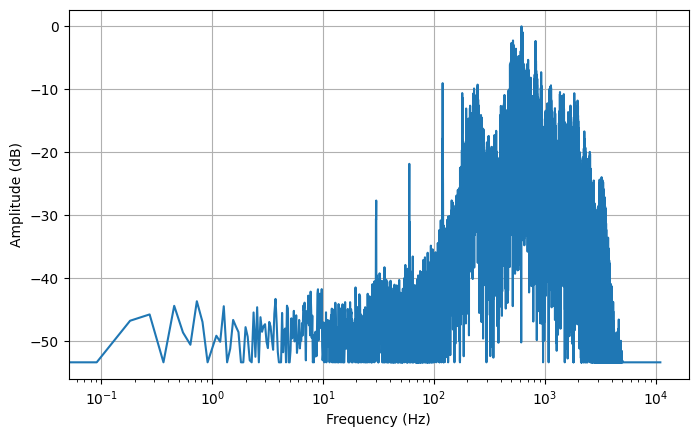

In [5]:
# dft_input = data[:sampling_rate]  # First 1 second
dft_input = data

# calculate the DFT
# window = np.hanning(len(dft_input))
# windowed_input = dft_input * window
# dft = np.fft.rfft(windowed_input, norm="backward")
dft = np.fft.rfft(dft_input, norm="forward")

# Taking the magnitude with np.abs(dft) extracts the amplitude information from the spectrogram
amplitude = np.abs(dft)
# get the amplitude spectrum in decibels
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(8)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid()
plt.xscale("log")

# Short-Time Fourier Transform (STFT)

## Split the audio data into ```N``` frames of size ```L```.

In [6]:
L = window_size = 1024    # Number of samples in the shoft-time frome
S = slide_size = 512

<img src="image/short_time_ft_windowing.png" align="left" width=500/>

In [7]:
def sliding_windows_on_1d_array(
        x: np.ndarray, window_size: int, slide_size: int
) -> np.ndarray:
    """Apply a sliding windows on a 1D array to create a (x-rows, d-columns) array.
    Truncate the trailing items that do not fit into the windows.

    Args:
        x: 1D array to apply the sliding windows.
        window_size: size of window to apply
        slide_size: step side to slide the window

    Returns: numpy array of shape (num_rows, window_size) where num_rows = ((x.size - window_size) // slide_size) + 1
    """
    assert 0 < window_size < x.size,\
        f"expected 0 < window_size < x.size:[{x.size}], got [{window_size}]."
    assert 0 < slide_size < x.size, \
        f"expected 0 < slide_size < x.size:[{x.size}], got [{slide_size}]."

    x = x.reshape(-1)
    num_rows = ((x.size - window_size) // slide_size) + 1
    item_size: int = x.strides[0]               # item size of an element in 1D array x.
    return np.lib.stride_tricks.as_strided(
        x,
        shape=(num_rows, window_size),          # result shape
        strides=(
            slide_size * item_size,             # stride[0] in the result shape (row size)
            item_size                           # stride[1] in the result shape (col size)
        )
    )

In [8]:
frames: np.ndarray = sliding_windows_on_1d_array(
    x=data,
    window_size=window_size,
    slide_size=slide_size
)

## Normalization

Normlization cannot be done after the window funciton is applied. Hence apply before.m

In [9]:
# frames = frames / np.sqrt(window_size)

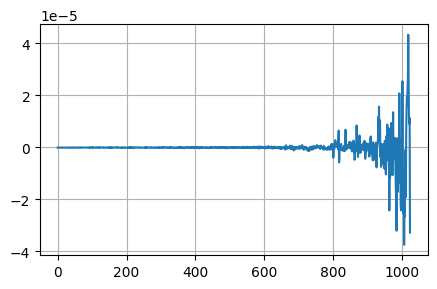

In [10]:
plt.figure(figsize=(5,3))
plt.grid()
plt.plot(frames[0])

## Applly Window Function

* [numpy.hamming](https://numpy.org/doc/stable/reference/generated/numpy.hamming.html)

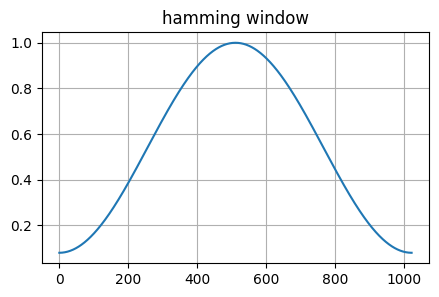

In [11]:
plt.figure(figsize=(5,3))
plt.title("hamming window")
plt.grid()
plt.plot(np.hamming(M=window_size))

In [12]:
windows = frames * np.hamming(M=window_size)
windows.shape

(472, 1024)

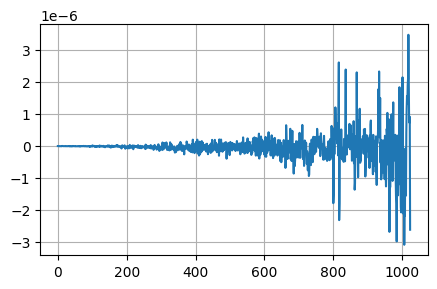

In [13]:
plt.figure(figsize=(5,3))
plt.grid()
plt.plot(windows[0])

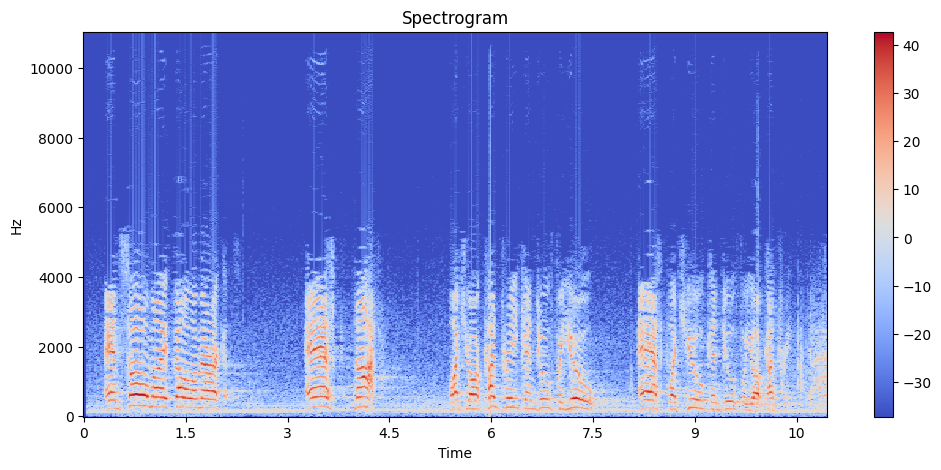

In [14]:
stft_transformed = np.fft.rfft(windows, norm="backward").T
display_stft_as_spectrogram(stft=stft_transformed, sampling_rate=sampling_rate, slide_size=slide_size)

# SFTF (librosa)

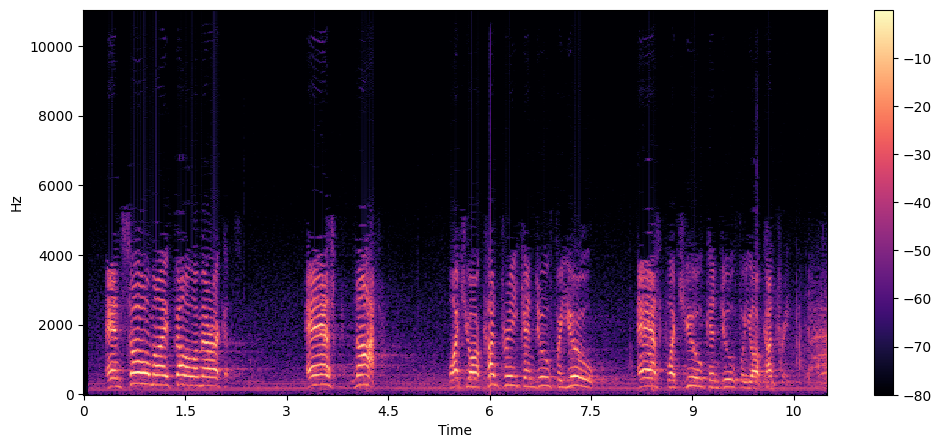

In [15]:
D = librosa.stft(data, n_fft=window_size, win_length=window_size, hop_length=slide_size, window=np.hamming(window_size))
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12,5))
librosa.display.specshow(
    S_db,
    sr=sampling_rate,
    hop_length=slide_size,
    x_axis="time", 
    y_axis="linear"
)
plt.colorbar()


## STFT (Xuan)

In [16]:
def stft_xuan(signal, window_size, hop_length):
    n_frames = 1 + (len(signal) - window_size) // hop_length
    stft_matrix = np.empty((window_size // 2 + 1, n_frames), dtype=complex)

    for i in range(n_frames):
        frame = signal[i * hop_length: i * hop_length + window_size]
        windowed_frame = frame * np.hamming(window_size)
        stft_matrix[:, i] = np.fft.rfft(windowed_frame)

    return stft_matrix

stft_matrix = stft_xuan(data, L, S)

## Spectrogram

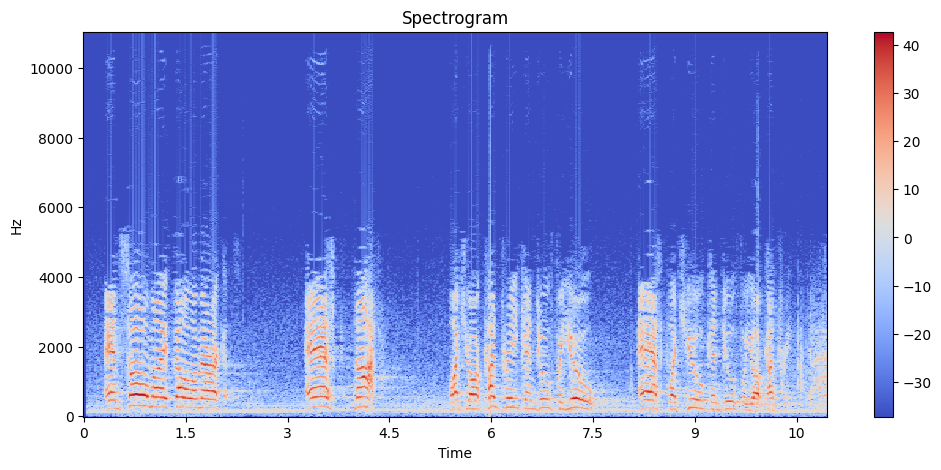

In [17]:
display_stft_as_spectrogram(stft_matrix, sampling_rate, slide_size)

# Mel Scale

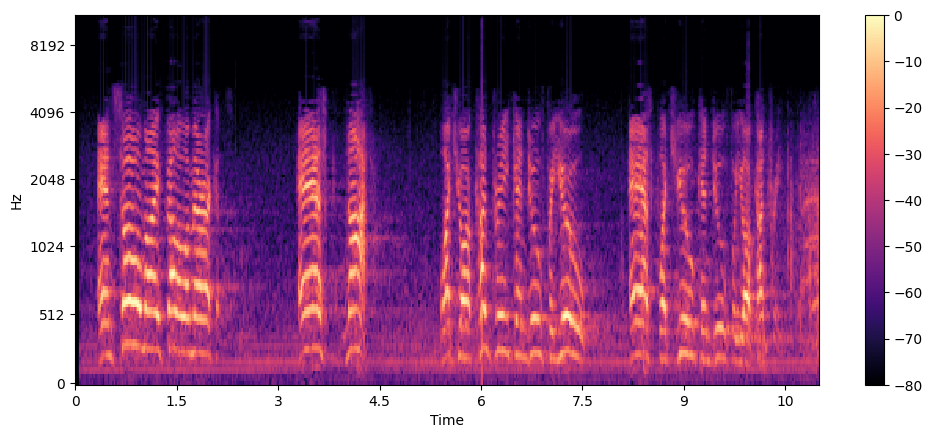

In [18]:
S = librosa.feature.melspectrogram(
    y=data, 
    sr=sampling_rate, 
    n_fft=window_size,
    hop_length=slide_size,
    win_length=window_size,
    window=np.hamming(window_size),
    n_mels=128, 
    fmax=sampling_rate / 2
)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=sampling_rate / 2)
plt.colorbar()